In [1]:
import json
from typing import TypedDict, Annotated, Literal
from IPython.display import Image, display

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage, BaseMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
model = ChatOpenAI(model='gpt-5-mini', temperature=0)

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

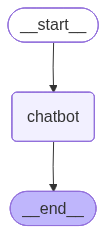

In [4]:
workflow = StateGraph(State)

def chatbot(state: State):
    return {'messages':[model.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)
workflow.set_entry_point('chatbot')
workflow.add_edge('chatbot', END)

app = workflow.compile()
app

In [5]:
while True:
    user_input = input('User: ')

    if user_input.lower() in ['quit', 'exit', 'q', '종료']:
        print('Good Bye!')
        break
    else:
        for event in app.stream({'messages':('user', user_input)}):
            for value in event.values():
                print(f'Assistant: {value['messages'][-1].content}')

Assistant: 안녕하세요! 저는 ChatGPT예요. 편하게 "ChatGPT"라고 불러주세요. 무엇을 도와드릴까요?
Good Bye!


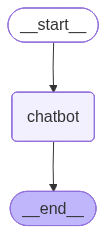

In [6]:
display(Image(app.get_graph().draw_mermaid_png()))

In [7]:
tool = TavilySearch(max_results=3)
tools = [tool]
tool.invoke('2025년 12월 18일 대한민국 서울의 날씨는?')

{'query': '2025년 12월 18일 대한민국 서울의 날씨는?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.chosun.com/national/transport-environment/2025/12/18/GWQHVUHWDRBGVE5ZTNTXBMCFMI/',
   'title': '[오늘의 날씨] 2025년 12월 18일 - 조선일보',
   'content': '오늘의 날씨 2025년 12월 18일 전국 대체로 맑음...미세먼지 농도 좋음∼보통.',
   'score': 0.8963332,
   'raw_content': None},
  {'url': 'https://ko.climate-data.org/%EC%95%84%EC%8B%9C%EC%95%84/%EB%8C%80%ED%95%9C%EB%AF%BC%EA%B5%AD/%EC%84%9C%EC%9A%B8/%EC%84%9C%EC%9A%B8-718563/t/12%EC%9B%94-12/',
   'title': '서울의 2025년 12월 날씨: 온도 및 기후',
   'content': '*   [중화인민공화국](https://ko.climate-data.org/%ec%95%84%ec%8b%9c%ec%95%84/%ec%a4%91%ed%99%94%ec%9d%b8%eb%af%bc%ea%b3%b5%ed%99%94%ea%b5%ad-110/). *   [지역 지역을 선택하십시오.](https://ko.climate-data.org/%ec%95%84%ec%8b%9c%ec%95%84/%eb%8c%80%ed%95%9c%eb%af%bc%ea%b5%ad-23/). *   [강원도](https://ko.climate-data.org/%ec%95%84%ec%8b%9c%ec%95%84/%eb%8c%80%ed%95%9c%eb%af%bc%ea%b5%ad/%ea%b0%95%ec%9b%90%eb%8f%84-1932/

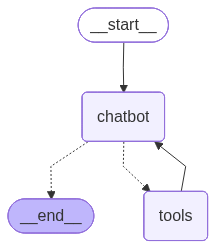

In [8]:
memory = MemorySaver()

workflow = StateGraph(State)

llm_with_tools = model.bind_tools(tools)
tool_node = ToolNode(tools=tools)

def chatbot(state: State):
    return {'messages':[llm_with_tools.invoke(state['messages'])]}

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.set_entry_point('chatbot')
workflow.add_conditional_edges(
    'chatbot',
    tools_condition
)
workflow.add_edge('tools', 'chatbot')

app = workflow.compile(checkpointer=memory)
app

In [9]:
config = {'configurable':{'thread_id':'1'}}
user_input = '안녕! 내 이름은 을지문덕이야. 네 이름은 뭐니?'

events = app.stream(
    {'messages':[('user', user_input)]},
    config,
    stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름은 을지문덕이야. 네 이름은 뭐니?
================================== Ai Message ==================================

안녕하세요, 을지문덕님! 저는 ChatGPT예요. 만나서 반가워요. 무엇을 도와드릴까요?


In [10]:
user_input = '안녕! 내 이름을 기억해?'

events = app.stream(
    {'messages':[('user', user_input)]},
    config,
    stream_mode='values'
)

for event in events:
    event['messages'][-1].pretty_print()

================================ Human Message =================================

안녕! 내 이름을 기억해?
================================== Ai Message ==================================

네, 기억하고 있어요 — 을지문덕님. 이 대화 안에서는 이름을 기억하지만, 세션이 끝나면 다음에 다시 알려주셔야 해요. 어떻게 불러드릴까요?


In [11]:
app = workflow.compile(
    checkpointer=memory,
    interrupt_before=['tools']
)

In [12]:
user_input = '지금 서울 날씨 어때?'
config = {'configurable':{'thread_id':'2'}}

events = app.stream(
    {'messages':[('user', user_input)]},
     config,
     stream_mode='values'
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

지금 서울 날씨 어때?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_DiB0QiCm803Gn4HaSgpMh9OW)
 Call ID: call_DiB0QiCm803Gn4HaSgpMh9OW
  Args:
    query: 서울 현재 날씨
    search_depth: basic
    topic: general


In [13]:
snapshot = app.get_state(config)
print(snapshot.next)

('tools',)


In [14]:
existing_message = snapshot.values['messages'][-1]
existing_message_id = existing_message.tool_calls[0]['id']

answer = '서울의 날씨는 매우 맑아요.'

new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message_id),
    AIMessage(content=answer)
]

app.update_state(
    config,
    {'messages':new_messages}
)

print(app.get_state(config).values['messages'][-2:])

[ToolMessage(content='서울의 날씨는 매우 맑아요.', id='84b0c9cb-99e9-419c-9630-83080120037a', tool_call_id='call_DiB0QiCm803Gn4HaSgpMh9OW'), AIMessage(content='서울의 날씨는 매우 맑아요.', additional_kwargs={}, response_metadata={}, id='e5655a12-2755-4d7d-8825-2843cf42aff9')]
